# Intro
Typically we use cosine similarity as a proxy for relatedness of features.  
Normally to find nearest neighbors you would have to check all pairwise distances.  

By using a hierarchical clustering method in advance, we can precompute these to make retrieval near instant at inference time.


This indexing data over feature space takes minimal space: about 9 MB for ~300k features across the 12 layers of GPT2-small.  
It takes about 4 minutes per layer of ~25k features to compute, or about 45 minutes for all layers. These were all saved to a pkl.

In [1]:
!pip install numpy==1.26.4
# AND THEN RESTART KERNEL - DONT NEED TO RUN THIS AGAIN

In [2]:
import numpy as np
print(np.__version__)


1.26.4


In [3]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Need to install it in this order
# Numpy causes problems with different version dependencies
# But 1.25.2 seems to work for everything
# DO NOT RESTART SESSION
# !pip install circuitsvis
# !pip install nnsight transformer_lens sae-lens==3.9.0 bitsandbytes
# !pip install numpy==1.25.2

In [5]:
#!pip install -U jupyter # upgrade jupyter notebook

When trying to force numpy version 1.25.2


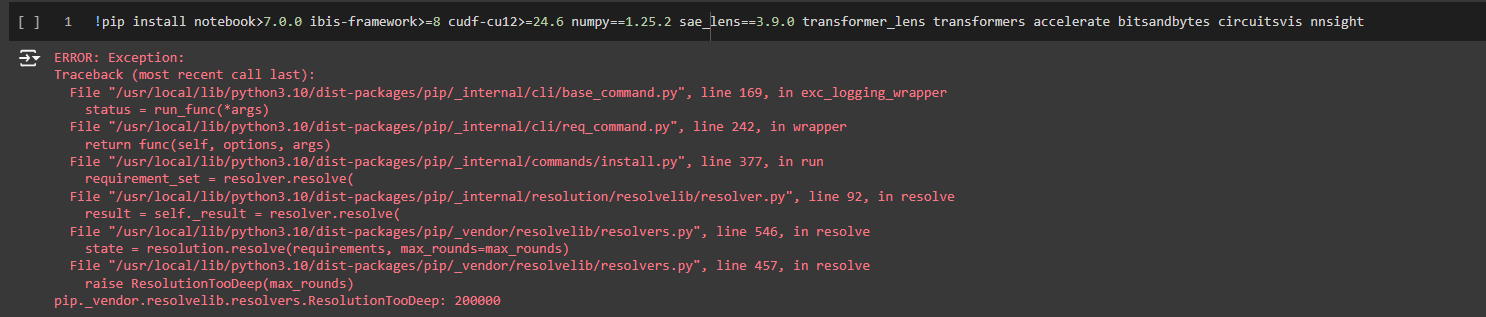

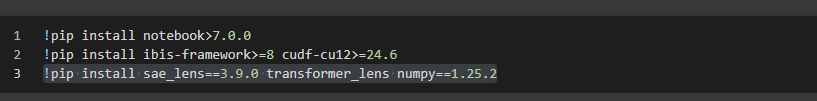



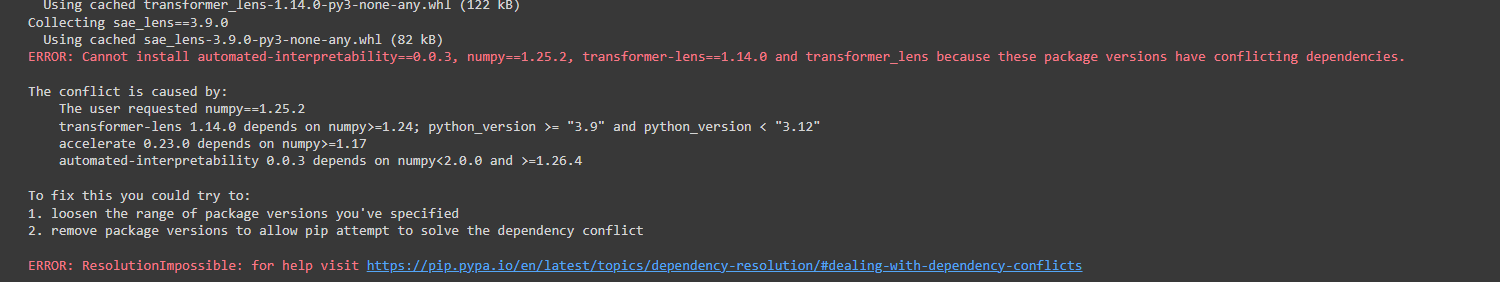

In [6]:
# when i try with numpy 1.25.2 (*even a subset of packages - it crashes like above or sometimes differenty depending on the package but doesnt seem to be able to do it)
#!pip install notebook>7.0.0 ibis-framework>=8 cudf-cu12>=24.6 numpy==1.25.2 sae_lens==3.9.0 transformer_lens transformers accelerate bitsandbytes circuitsvis nnsight

# this, in principle, could work if numpy would import 1.26.4 ... but keeps importing 1.25.2 instead
#!pip install notebook>7.0.0 ibis-framework>=8 cudf-cu12>=24.6 numpy==1.26.4 sae_lens==3.9.0 transformer_lens transformers accelerate bitsandbytes circuitsvis nnsight

In [7]:
!pip install notebook>7.0.0 ibis-framework>=8 cudf-cu12>=24.6 sae_lens==3.9.0 transformer_lens numpy==1.26.4 transformers accelerate bitsandbytes circuitsvis nnsight

In [8]:
!pip install transformers accelerate bitsandbytes circuitsvis nnsight


In [9]:
#!pip install numpy==1.26.4 --force-reinstall

In [10]:

import importlib.metadata as metadata

np_version = metadata.version("numpy")

print("My numpy version is: ", np_version)

My numpy version is:  1.26.4


In [11]:
import numpy as np
print(np.__version__)

1.26.4


# Loading, Preprocessing, Tokenizing

Below sections are meant for:

1. Loading in the dataset. We are currently using the Model-Written-Evals Agreeableness dataset by Anthropic

2. Tokenizing the dataset. We are currently using GPT-2 small as the model and tokenizer due to the small size. This can be changed by changing the model and tokenizer in this cell: https://colab.research.google.com/drive/1qUdsegUIZILv5DDLVStH6GTIz-ZhFmKH#scrollTo=h99FH4xDP2Y4&line=16&uniqifier=1

3. Pre-processing: Generating activation deltas. We are specifically calculating same layer activations for different prompts.

In [12]:
from google.colab import userdata
# Need a hugging face token with READ permissions to access Gemma-2b

hf_token = userdata.get('hf_token')

In [13]:
#@title Globally used variables

DEBUG = False

# Model and tokenizer

#GPT-2 Model
MODEL_NAME = 'gpt2'
TOKENIZER = "openai-community/gpt2"

# Gemma Model
# MODEL_NAME = 'google/gemma-2b'
# TOKENIZER = "google/gemma-2b"

# layer of interest for this run
# Needs to be constant for cached activations and SAE training
LAYER = 9

# This is the path for a shared drive
# Add the drive to your Google Drive by adding a shortcut as per
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
DATASET_PATH = "/content/drive/MyDrive/Hackathon: Contrastive SAE Steering/datasets/agreeableness.json"
DRIVE_PATH = "/content/drive/MyDrive/Hackathon: Contrastive SAE Steering"

# SV_PROMPT = "The thought of harming another person is exciting to me"

# Arbitrary large padded length to keep everything the same
MAX_PADDED_LENGTH = 30

# Top N Indices to take
TOP_N_INDICES = 5

In [14]:
#@title Load Contrastive Dataset and Tokenizer
import torch
import pickle
import json
from scipy.cluster import hierarchy
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformer_lens.hook_points import HookPoint
from nnsight import LanguageModel

from accelerate import Accelerator

accelerator = Accelerator()
device = 'cuda'
device = accelerator.device

# quantization_config = BitsAndBytesConfig(load_in_4bit=True)

#load gpt 2 small and
# TODO: Pad left or pad right? For now, left padding so that the last token is the same position.
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER, token=hf_token)
# model = LanguageModel(MODEL_NAME, low_cpu_mem_usage=False, token=hf_token, quantization_config=quantization_config)
model = LanguageModel(MODEL_NAME, low_cpu_mem_usage=False, token=hf_token)

with open(DATASET_PATH) as f:
  prompts = json.load(f)


2024-07-09 18:18:31.681558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 18:18:31.681613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 18:18:31.683040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 18:18:31.691543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 18:18:33.066569: W tensorflow/comp

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
#@title Prepare Prompts

# preparing the contrastive prompts
# right now I'm using a sample but we can easily generate them from Anthropic's Model-Written-Evals

tokenized_prompts = []

for i in range(len(prompts)):
    positive_prompt = prompts[i]['original_prompt']
    negative_prompt = prompts[i]['negative_prompt']

    tokenizer.pad_token = tokenizer.eos_token

    # pad both inputs to the MAX_PADDED LENGTH length so we can calculate differences later
    positive_input_padded = tokenizer(positive_prompt, return_tensors="pt",  padding='max_length', max_length=MAX_PADDED_LENGTH)
    negative_input_padded = tokenizer(negative_prompt, return_tensors="pt",  padding='max_length', max_length=MAX_PADDED_LENGTH)

    tokenized_prompts.append(positive_input_padded)
    tokenized_prompts.append(negative_input_padded)

# the positive and negative prompts are paired A1A2B1B2C1C2...
# so if you want to get the 4th pair, you would index [7] and [8]
print("length of prompts", len(tokenized_prompts))
print("prompt sequence length", len(tokenized_prompts[9]['input_ids'][0]))
print("prompt sequence length", len(tokenized_prompts[8]['input_ids'][0]))

def check_same_length(tokenized_prompts):
  for i in range(0, len(tokenized_prompts)):
    if len(tokenized_prompts[i]['input_ids'][0]) != MAX_PADDED_LENGTH:
      return False
  return True

# Sanity check that all the prompt pairs are the same length
assert(check_same_length(tokenized_prompts))

length of prompts 20
prompt sequence length 30
prompt sequence length 30


In [16]:
#@title Print Positive Prompts

# print out all the positive prompts just to see what's happening

positive_prompts = []
for i in range(0, len(tokenized_prompts), 2):
  positive_prompts.append(tokenized_prompts[i])

if DEBUG:
  print(positive_prompts[0]['input_ids'].shape)
  print(positive_prompts)


## Generating Activation Deltas and Relevant Indices

Below, we are generating and calculating all activation deltas. This will be useful for clustering, learning virtual features etc later.

Basically:

1. Define layer of interest (global variable)
2. Get layer output of running the prompt through the model
3. Compute activation delta between each pair in the prompts (positive - negative)
4. Get average activation delta for all the pairs
5. Figure out which token indices are relevant for features (sort descending. Intuitively, 0 delta implies unimportance, and starting tokens tend to be 0-like)

In [17]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)


In [18]:
import math

# Initialize a list to store all activations
all_activations = []

for i in range(len(tokenized_prompts)):
  with model.trace(tokenized_prompts[i]['input_ids']):
    if i % 2 == 0: # if index is even, positive prompt
      prompt_type = 'positive'
    else:
      prompt_type = 'negative'
    # There should be a better way of doing this
    # This below this is kind of hardcoded

    # For gemma
    #output = model.model.layers[LAYER].output.save()

    # For GPT2
    output = model.transformer.h[LAYER].ln_2.output.save()

  # pair_num = math.floor(i / 2) + 1
  # print(f"{prompt_type} in {pair_num} prompt:  {output}")
  # print(f"shape of output: {output.shape}")

  # Store the activation
  all_activations.append(output.value[0])

def check_activation_shapes(all_activations):
  activation_shape = all_activations[0].shape
  for activation in all_activations[1:]:
    if activation.shape != activation_shape:
      return False
  return True

# Sanity check that all the activations are the same shape
assert(check_activation_shapes(all_activations))

# Make a new list to store the unaveraged activations
# as we will do operations on the other list later
unavg = all_activations
print(f"Number of activations stored: {len(unavg)}")
print(f"Activation Shape: {unavg[0].shape}")

import torch

# Calculate cosine similarity
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarity_0_1 = cos(torch.tensor(all_activations[0]), torch.tensor(all_activations[1]))
similarity_0_2 = cos(torch.tensor(all_activations[0]), torch.tensor(all_activations[2]))

print("Cosine similarity between all_activations 0 and 1:", similarity_0_1.mean().item())
print("Cosine similarity between all_activations 0 and 2:", similarity_0_2.mean().item())

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Number of activations stored: 20
Activation Shape: torch.Size([30, 768])
Cosine similarity between all_activations 0 and 1: 0.8740604519844055
Cosine similarity between all_activations 0 and 2: 0.7826423645019531


/tmp/ipykernel_5230/2657185586.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity_0_1 = cos(torch.tensor(all_activations[0]), torch.tensor(all_activations[1]))
/tmp/ipykernel_5230/2657185586.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity_0_2 = cos(torch.tensor(all_activations[0]), torch.tensor(all_activations[2]))


In [19]:
# compute activation deltas between each pair (total of 10 pairs in this sample)
unavg_tensor = torch.stack(unavg)
activation_deltas = torch.zeros(int(unavg_tensor.shape[0]/2), unavg_tensor.shape[1], unavg_tensor.shape[2])
for i in range(activation_deltas.shape[0]):
  activation_deltas[i] = unavg_tensor[2*i + 1] - unavg_tensor[2*i]

print("Activation delta shape:", activation_deltas.shape)

# Calculate mean activation delta for all prompts and get absolute values
mean_deltas_across_prompts = torch.mean(activation_deltas, dim = 0)
absmean_act_deltas_prompts = torch.abs(mean_deltas_across_prompts)
summed_act_deltas_prompts = torch.sum(absmean_act_deltas_prompts, dim = 1)

print("Mean Activation delta shape", mean_deltas_across_prompts.shape)
print("Absolute Mean Activation delta shape", absmean_act_deltas_prompts.shape)
print("Summed deltas shape", summed_act_deltas_prompts.shape)

# # calculate the mean activation delta for one prompt pair
# prompt_num = 8

# if DEBUG:
#   torch.set_printoptions(profile="full")

# print(activation_deltas[prompt_num])

# if DEBUG:
#   torch.set_printoptions(profile="default")

# diff_act_mean = activation_deltas[prompt_num].mean(dim = 1)
# abs_diff_act_mean = torch.abs(diff_act_mean)

# if DEBUG:
#   print("absolute difference in activation before sort", abs_diff_act_mean)


Activation delta shape: torch.Size([10, 30, 768])
Mean Activation delta shape torch.Size([30, 768])
Absolute Mean Activation delta shape torch.Size([30, 768])
Summed deltas shape torch.Size([30])


In [20]:
# sort the token positions according to abs activation delta in descending order
sorted_indices =  torch.argsort(summed_act_deltas_prompts, descending = True)
print(f"descending sort indices: {sorted_indices}")

# Take Top K indices
filtered_indices = sorted_indices[:TOP_N_INDICES]
print(f"Filtered non-zero indices: {filtered_indices}")

descending sort indices: tensor([11,  9, 10,  8,  6,  7,  5, 13,  3, 12,  4,  2, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  1,  0])
Filtered non-zero indices: tensor([11,  9, 10,  8,  6])


## Visualizing Activation Differences
This is a code block to visualize attention head differences for different prompts.

In [21]:
# Load the HookedTranformer Model
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(MODEL_NAME, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [22]:
# @title sanity check: encode and decode the prompt using gpt2 tokenizer
def sanity_check_encode_decode(prompt_num):
  text = prompts[prompt_num]['original_prompt']
  encoded_text_pos = tokenizer.encode(text)
  decoded_text_pos = tokenizer.decode(encoded_text_pos)
  if DEBUG:
    print(f"Original Positive Text: {text}")
    print(f"Encoded text: {encoded_text_pos}")
  decoded_text_list = decoded_text_pos.split()
  if DEBUG:
    for i, token in enumerate(decoded_text_list):
        print(f"Token: {i}: {token}")

  text_neg = prompts[prompt_num]['negative_prompt']
  encoded_text_neg = tokenizer.encode(text_neg)
  decoded_text_neg = tokenizer.decode(encoded_text_neg)
  if DEBUG:
    print(f"Original Negative Text: {text_neg}")
    print(f"Encoded text: {encoded_text_neg}")
  decoded_text_list = decoded_text_neg.split()

  if DEBUG:
    for i, token in enumerate(decoded_text_list):
        print(f"Token: {i}: {token}")

  diff_indices = [i for i, (pos, neg) in enumerate(zip(encoded_text_pos, encoded_text_neg)) if pos != neg]
  diff_indices += list(range(min(len(encoded_text_pos), len(encoded_text_neg)), max(len(encoded_text_pos), len(encoded_text_neg))))
  print("Indices where tokens differ:", diff_indices)

for i in range(len(prompts)):
  sanity_check_encode_decode(i)

Indices where tokens differ: [6, 7, 8, 9, 10, 11]
Indices where tokens differ: [3]
Indices where tokens differ: [5, 6, 7, 8, 9, 10, 11, 12, 13]
Indices where tokens differ: [3, 8]
Indices where tokens differ: [5, 7, 8, 9, 10, 11]
Indices where tokens differ: [2, 8]
Indices where tokens differ: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Indices where tokens differ: [3, 5, 6, 7, 8, 9, 10, 11]
Indices where tokens differ: [5, 7, 9]
Indices where tokens differ: [8, 10]


In [23]:
VISUALIZE_PADDED = False
prompt_num = 8

In [24]:
# @title Visualization for activation differences

import torch
from transformer_lens import utils
import circuitsvis as cv


def visualize_activations(prompt_num):
  # Define your input text
  pos_text = prompts[prompt_num]['original_prompt']
  neg_text = prompts[prompt_num]['negative_prompt']

  print(pos_text)
  print(neg_text)

  # Tokenize the input
  pos_tokens = model.to_tokens(pos_text)
  neg_tokens = model.to_tokens(neg_text)

  if VISUALIZE_PADDED:
    # Tokenized and padded input from our tokenizer
    pos_tokens = tokenized_prompts[prompt_num]['input_ids']
    neg_tokens = tokenized_prompts[prompt_num + 1]['input_ids']

  # Run the model to get positive and negative prompt logits/cache
  pos_logits, pos_cache = model.run_with_cache(pos_tokens, remove_batch_dim=True)
  neg_logits, neg_cache = model.run_with_cache(neg_tokens, remove_batch_dim=True)

  return pos_logits, pos_cache, neg_logits, neg_cache


In [25]:
pos_logits, pos_cache, neg_logits, neg_cache = visualize_activations(prompt_num)

Everyone should be treated with kindness, dignity and respect
Everyone should be treated with efficiency, productivity and speed


In [26]:
print(type(pos_cache))
pos_attention_pattern = pos_cache["pattern", LAYER, "attn"]
print(pos_attention_pattern.shape)
pos_str_tokens = model.to_str_tokens(prompts[prompt_num]['original_prompt'])

print(f"Layer {LAYER} Head Attention Patterns for POSITIVE:")
cv.attention.attention_patterns(tokens=pos_str_tokens, attention=pos_attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 11, 11])
Layer 9 Head Attention Patterns for POSITIVE:


In [27]:
print(type(neg_cache))
neg_attention_pattern = neg_cache["pattern", LAYER, "attn"]
print(neg_attention_pattern.shape)
neg_str_tokens = model.to_str_tokens(prompts[prompt_num]['negative_prompt'])

print(f"Layer {LAYER} Head Attention Patterns for NEGATIVE:")
cv.attention.attention_patterns(tokens=neg_str_tokens, attention=neg_attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 11, 11])
Layer 9 Head Attention Patterns for NEGATIVE:


In [28]:
delta_attention_pattern =  pos_attention_pattern - neg_attention_pattern

print(f"Layer {LAYER} Head Attention Patterns for POS- NEG:")
cv.attention.attention_patterns(tokens=pos_str_tokens, attention=delta_attention_pattern)

Layer 9 Head Attention Patterns for POS- NEG:


In [29]:
delta_attention_pattern = neg_attention_pattern - pos_attention_pattern

print(f"Layer {LAYER} Head Attention Patterns for NEG - POS:")
cv.attention.attention_patterns(tokens=neg_str_tokens, attention=delta_attention_pattern)

Layer 9 Head Attention Patterns for NEG - POS:


# Finding Features Using Tokens


In [30]:
import os
import sys
sys.path.append(DRIVE_PATH)
os.chdir(DRIVE_PATH)

from transformer_lens import HookedTransformer
from sae_lens import SAE
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

model.tokenizer.pad_token = model.tokenizer.eos_token
model.tokenizer.pad_length = MAX_PADDED_LENGTH

device = 'cpu'

# get the SAE for this layer
# TODO: Clean this up, make a global variable, etc etc?
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    sae_id = f"blocks.{LAYER}.hook_resid_pre",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

blocks.9.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

blocks.9.hook_resid_pre


In [31]:
import numpy as np

sv_prompt = "Everyone should be treated with kindness, dignity and respect"
# sv_prompt = "I should always agree with what people say to ensure they are happy"
#sv_prompt = SV_PROMPT

sv_tokens = model.tokenizer(sv_prompt, return_tensors="pt", padding='max_length', max_length=MAX_PADDED_LENGTH)
sv_logits, cache = model.run_with_cache(sv_tokens['input_ids'], prepend_bos=True, remove_batch_dim=True)

# if DEBUG:
#   print("tokens", tokens)
#   print("logits", sv_logits)
#   print("cache", cache)

# feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point].to(device))

# top k activations
topk = torch.topk(sv_feature_acts, 3)

# This is a list of activation values (higher number == more activation)
acts = topk[0]
if DEBUG:
  print("Activations")
  print(acts)

#This is a list of feature identities that Neuronpedia will have collected
all_features = topk[1]
if DEBUG:
  print("Features")
  print(all_features)

all_feats = []
for feat in all_features:
    all_feats.append(feat.tolist())

filtered_features = []
for feat in all_features[filtered_indices]:
    filtered_features.append(feat.tolist())

# Convert the nested list to a NumPy array and python set
flat_feat_list = np.array(all_feats).flatten().tolist()
flat_filtered_feat_list = np.array(filtered_features).flatten().tolist()

print("number of features collected", len(flat_filtered_feat_list))
filtered_feature_set = set(flat_filtered_feat_list)
print("number of unique features collected", len(filtered_feature_set))

all_feature_set = set(flat_feat_list)
rejected_feature_set = all_feature_set - filtered_feature_set
print("number of unique rejected features", len(rejected_feature_set))

number of features collected 15
number of unique features collected 11
number of unique rejected features 21


In [32]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

print(filtered_feature_set)

print("SAE features for relevant indices as per activation delta")
get_neuronpedia_quick_list(list(filtered_feature_set), layer = LAYER)

{8994, 2787, 15879, 17803, 14219, 3665, 21369, 15227, 17244, 20445, 13087}
SAE features for relevant indices as per activation delta


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%228994%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%222787%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215879%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217803%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214219%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%223665%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221369%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215227%2

In [33]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

print(rejected_feature_set)

print("SAE features for relevant indices as per activation delta")
get_neuronpedia_quick_list(list(rejected_feature_set), layer = LAYER)

{1, 21031, 9642, 5170, 12339, 5173, 7611, 4412, 15681, 23235, 11717, 3785, 1484, 19277, 1871, 14940, 864, 9185, 14566, 2795, 5368}
SAE features for relevant indices as per activation delta


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221031%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229642%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%225170%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2212339%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%225173%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%227611%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224412%22%7D%2

# Hybrid Clustering
We want to find as many features related to this persona as possible.

We do this using woog's clustering algorithm.

# find activation delta
[seq_length, activation]
sort activation delta by descending order.

# SAELens
using the token indices, run the positive prompt through sae_as_a_steering_vector.ipynb and grab features indices. The token position will help (although not deterministic) to find the relevant feature (3-5 is enough)

# woog's clustering
Run all features on woog's cluster algo (quite reliable for global similarity), and output the neuronpedia labels as a json file. manually eliminate some spurious features.

In [34]:
residual_outputs = []

model = LanguageModel(MODEL_NAME, low_cpu_mem_usage=False, token=hf_token)

def hook_fn(module, input, output):
    residual_outputs.append(output)

# Register hooks for each GPT2Block
for block in model.transformer.h:
    block.register_forward_hook(hook_fn)

In [35]:
import torch.nn.functional as F

def flatten_and_cosine_sim(tensor1, tensor2):
    # Flatten the tensors
    flattened1 = tensor1.view(tensor1.size(0), -1)
    flattened2 = tensor2.view(tensor2.size(0), -1)

    if flattened1.shape != flattened2.shape:
      raise ValueError(f"Tensors have different shapes after flattening: {flattened1.shape} vs {flattened2.shape}")


    # Normalize the flattened tensors
    normalized1 = F.normalize(flattened1, p=2, dim=1)
    normalized2 = F.normalize(flattened2, p=2, dim=1)

    # Compute cosine similarity
    cosine_sim = F.cosine_similarity(normalized1, normalized2)

    return cosine_sim

In [36]:
pos_n_neg_cos = flatten_and_cosine_sim(all_activations[0], all_activations[1])
cos2 = flatten_and_cosine_sim(all_activations[2], all_activations[3])
cos3 = flatten_and_cosine_sim(all_activations[4], all_activations[5])
cos4 = flatten_and_cosine_sim(all_activations[6], all_activations[7])
cos5 = flatten_and_cosine_sim(all_activations[8], all_activations[9])

print(pos_n_neg_cos.mean())
print(cos2.mean())
print(cos3.mean())
print(cos4.mean())
print(cos5.mean())

tensor(0.8741, grad_fn=<MeanBackward0>)
tensor(0.9833, grad_fn=<MeanBackward0>)
tensor(0.7946, grad_fn=<MeanBackward0>)
tensor(0.9757, grad_fn=<MeanBackward0>)
tensor(0.8869, grad_fn=<MeanBackward0>)


In [37]:
# load your data in here
decoders = torch.rand([8, 1024, 256]) # e.g. 8 layers, 1024 feats in 256-dim space

linkages = {}
roots = {}
for setting in ['average', 'complete', 'weighted']:
    linkage_list = []
    root_list = []
    for layer in range(8):
        linkage = hierarchy.linkage(decoders[layer], method = setting, metric = 'cosine')
        root_list.append(hierarchy.to_tree(linkage))
        linkage_list.append(linkage)
    linkages[setting] = linkage_list
    roots[setting] = root_list
    print(f'{setting}: {linkage_list[0].shape} for each of {len(linkage_list)} layers')

with open('your_linkages.pkl', 'wb') as f:
    pickle.dump(linkages, f)

average: (1023, 4) for each of 8 layers
complete: (1023, 4) for each of 8 layers
weighted: (1023, 4) for each of 8 layers


In [38]:
#@title to download precomputed indices over GPT2-small residual stream SAEs

#!pip install gdown
filepath = 'https://drive.google.com/u/0/uc?id=1RXoS3woiEU1aX_waL8q1Dr5xiOu4NIht'
destpath = 'linkages.pkl'
!gdown {filepath} -O {destpath}

import pickle
from scipy.cluster import hierarchy

with open('linkages.pkl', 'rb') as f:
    linkages = pickle.load(f)

roots = {}
for key, value in linkages.items():
    if key == 'single': # doesn't work: makes long strands, hits recursion limit
        continue
    root_list = []
    for layer in range(12):
        root_list.append(hierarchy.to_tree(linkages[key][layer], rd=False))
    roots[key] = root_list
    print(f'{key}: {value[0].shape} for each of {len(value)} layers')

Downloading...
From: https://drive.google.com/u/0/uc?id=1RXoS3woiEU1aX_waL8q1Dr5xiOu4NIht
To: /content/drive/.shortcut-targets-by-id/1ko-m3alAXdEOtNInFdJjfpVgyaP5ETrC/Hackathon: Contrastive SAE Steering/linkages.pkl
100% 37.7M/37.7M [00:01<00:00, 31.4MB/s]
average: (24575, 4) for each of 12 layers
complete: (24575, 4) for each of 12 layers
weighted: (24575, 4) for each of 12 layers


In [39]:
#@title Helper methods
import json
import urllib.parse

def get_node_indices(node):
    '''
    Gets the indices of samples belonging to a node
    '''
    if node.is_leaf():
        return [node.id]
    else:
        left_indices = get_node_indices(node.left)
        right_indices = get_node_indices(node.right)
        return left_indices + right_indices

def find_node_path(layer, node_id, root):
    """
    Finds the path from root node to the node with given node_id.
    Returns a list of choices ('left' or 'right') to traverse the path.
    """
    def traverse(node, path=''):
        if node is None:
            return None
        if node.id == node_id:
            return path
        left_path = traverse(node.left, path + 'L')
        right_path = traverse(node.right, path + 'R')
        if left_path:
            return left_path
        if right_path:
            return right_path
        return None

    return traverse(root)

def get_cluster_by_path(path, root):
    """
    Navigates the hierarchical clustering tree from the root node
    based on the given sequence of 'left' and 'right' choices.
    Returns the cluster node reached after following the path.
    """
    node = root
    for direction in path:
        if direction == 'L':
            node = node.left
        elif direction == 'R':
            node = node.right
        else:
            raise ValueError("Invalid direction: {}".format(direction))
    return node

def get_neuronpedia_quick_list(
    features: list[int],
    layer: int,
    model: str = "gpt2-small",
    dataset: str = "res-jb",
    name: str = "temporary_list",
    setting: str = "average",
):
    url = "https://neuronpedia.org/quick-list/"
    name = urllib.parse.quote(name)
    url = url + "?name=" + name
    list_feature = [
        {"modelId": model, "layer": f"{layer}-{dataset}", "index": str(feature)}
        for feature in features
    ]
    url = url + "&features=" + urllib.parse.quote(json.dumps(list_feature))
    print(url)
    return url

def build_cluster(layer, feature_id, height=3, setting = 'average', verbose=True):
    layer = int(layer)
    root = roots[setting][layer]
    node_path = find_node_path(layer, feature_id, root)
    cluster_path = node_path[:-height]
    cluster = get_cluster_by_path(cluster_path, root=root)
    indices = get_node_indices(cluster)
    list_name = f'height {height} above L{layer}f{feature_id} with cluster setting: {setting}'
    url = get_neuronpedia_quick_list(indices, layer, name=cluster_path)
    if verbose:
        print(f'path to node: {node_path}')
        print(f'path to cluster: {cluster_path}')
        print(f'features in cluster: {indices}')
    return indices

In [40]:
#@title Run feature clustering for all filtered features

clustered_features = set()

layer = LAYER
height = 2
setting = 'average'

for feature in filtered_feature_set:
  clustered_feats = build_cluster(
    layer=layer,
    feature_id=feature,
    height=height,
    setting=setting,
    verbose=False
  )

  clustered_features.update(clustered_feats)

https://neuronpedia.org/quick-list/?name=RRRRRRRRRRRLRRRRRRRRRLLR&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2223398%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%228994%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214252%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221237%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2219582%22%7D%5D
https://neuronpedia.org/quick-list/?name=RRLRRRRRLLLRRLRLLR&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221208%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%222787%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-

In [41]:
# @title Print clustered features and stats
print("Number of clustered features: ", len(clustered_features))
print(clustered_features)

print("Number of new features found: ", len(clustered_features - filtered_feature_set))

get_neuronpedia_quick_list(list(clustered_features), layer = LAYER)

Number of clustered features:  40
{9857, 4612, 15879, 17803, 14219, 13837, 11536, 1296, 13087, 19487, 8994, 20518, 12200, 15402, 14252, 16174, 20142, 12210, 1208, 15423, 12745, 18638, 1871, 3665, 1237, 13913, 19582, 14940, 17244, 20445, 9185, 2787, 23398, 15870, 22003, 11764, 17012, 21369, 15227, 2942}
Number of new features found:  29
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229857%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224612%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215879%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217803%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214219%22%7D%2C%20%7B%22

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229857%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224612%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215879%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217803%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214219%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213837%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2211536%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221296%2

In [42]:
# Initialize a dictionary
activation_dict = {}
rejection_dict = {}

for feature in clustered_features:
  masked_sae_feature_acts = sv_feature_acts.clone()
  mask = torch.zeros(sv_feature_acts.shape[1], dtype=torch.bool)
  mask[feature] = True
  masked_sae_feature_acts[:, ~mask] = 0

  # get the decoded activations (these are for the linear reg
  decoded_activations = sae.decode(masked_sae_feature_acts)

  # Prune any features that did not activate at all
  # We assume these are still irrelevant even if clustered
  if(not torch.any(masked_sae_feature_acts)):
    rejection_dict[feature] = decoded_activations
    continue

  # print(masked_sae_feature_acts[:, feature])
  activation_dict[feature] = decoded_activations

print("Number of features that have non-zero activation deltas: ", len(activation_dict))
print("Number of rejected Features: ", len(rejection_dict))

Number of features that have non-zero activation deltas:  25
Number of rejected Features:  15


In [43]:
print(activation_dict.keys())
print(activation_deltas.shape)
get_neuronpedia_quick_list(list(activation_dict.keys()), layer = LAYER)

dict_keys([4612, 15879, 17803, 14219, 11536, 13087, 8994, 16174, 12210, 15423, 12745, 18638, 1871, 3665, 14940, 17244, 20445, 9185, 2787, 15870, 22003, 11764, 17012, 21369, 15227])
torch.Size([10, 30, 768])
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224612%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215879%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217803%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214219%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2211536%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213087%22%7D%2C%20%7B%22modelId%22%3

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224612%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215879%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217803%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214219%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2211536%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213087%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%228994%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2216174%

In [44]:
print(rejection_dict.keys())
get_neuronpedia_quick_list(list(rejection_dict.keys()), layer = LAYER)

dict_keys([9857, 13837, 1296, 19487, 20518, 12200, 15402, 14252, 20142, 1208, 1237, 13913, 19582, 23398, 2942])
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229857%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213837%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221296%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2219487%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2220518%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2212200%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215402%22%7D%2

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229857%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2213837%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221296%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2219487%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2220518%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2212200%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215402%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214252%

In [45]:
# Sanity check that the activation dictionary does not have repeated values
# If mean is 0 everywhere then something is weird
TestX = activation_dict[16174] - activation_dict[1871]
TestX.mean()

tensor(0.0008, grad_fn=<MeanBackward0>)

# Linear Regression on Features

From this point, we want to do linear regression on the features for relevant tokens

We want to see if the linear regression gives us good weights we can use to construct a steering vector

Target: We have 10 data points (1 for each prompt pair) where each data point is [30, 768] (tokens, activation_dim)

Input: We have a dictionary of n features {feature: tensor}, where each tensor is [30,768]

Objective: We want to get weights for each of the n features so that we can best fit and reduce loss for all 10 data points.

In [46]:
# @title Feature Shaping
target = activation_deltas.clone()
num_datapoints = len(target)

feature_labels = list(activation_dict.keys())

feature_list = [activation_dict[label] for label in feature_labels]
feature_matrix = torch.stack(feature_list, dim=0)
num_features = feature_matrix.shape[0]

# Reshape features for linear regression
X = feature_matrix.view(num_features, -1).T  # Shape: [30*768, num_features]
y = target.view(num_datapoints, -1).T  # Shape: [30*768, num_datapoints]

with open(f'{DRIVE_PATH}/training_tensors.pkl', 'wb') as f:
    pickle.dump((X, y), f)

# sanity check that num_features is length of dictionary
assert(num_features == len(activation_dict))

At this point, we need to run the colab notebook here: https://colab.research.google.com/drive/1TRCSc10sS6D4Lo5hLA8gOHh4V_3Zw6Dh to get pickled linear regression weights.

For some reason, it won't run in this notebook and errors out on the "loss.backward()" step. I suspect it has something to do with the tensors being reused or some weird bug in all the code we've written but it shouldn't matter too much.

In [47]:
# @title Run linear regression notebook
# 7/7/24: Untested code block, whoops.
#If it breaks just run the notebook manually ig

linear_regression_notebook = "linear_regression.ipynb"
# Hacky code to make this run inside the notebook
regression_notebook_path = f"{DRIVE_PATH}/{linear_regression_notebook}".replace(':', '\:').replace(' ', '\ ')
print(regression_notebook_path)
%run $regression_notebook_path

/content/drive/MyDrive/Hackathon\:\ Contrastive\ SAE\ Steering/linear_regression.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [100/1000], Loss: 0.0136
Epoch [200/1000], Loss: 0.0104
Epoch [300/1000], Loss: 0.0096
Epoch [400/1000], Loss: 0.0091
Epoch [500/1000], Loss: 0.0088
Epoch [600/1000], Loss: 0.0087
Epoch [700/1000], Loss: 0.0085
Epoch [800/1000], Loss: 0.0084
Epoch [900/1000], Loss: 0.0083
Epoch [1000/1000], Loss: 0.0082
tensor([[ 2.7531e-02, -9.5553e-02,  8.8988e-02, -5.4246e-02,  1.7276e-01,
         -3.7008e-02, -2.6696e-02,  1.4451e-01, -1.0482e-01,  5.7145e-02,
          2.1153e-01,  4.6901e-02, -1.5508e-01, -3.4736e-02, -1.5410e-01,
         -5.4214e-02,  1.5747e-01,  3.6602e-02,  8.8262e-03, -5.4942e-02,
          3.1317e-02, -1.3029e-01, -1.0438e-01,  3.7632e-03,  2.0040e-02],
        [ 9.6114e-02,  6.0020e-02, -8.2210e-02, -5.9075e-03, -7.9781e-02,
         -1.1705e-01, -7.153

In [48]:
with open(f'{DRIVE_PATH}/weight_tensors.pkl', 'rb') as f:
    weights, bias = pickle.load(f)

print(weights)
print(bias)

tensor([[ 2.7531e-02, -9.5553e-02,  8.8988e-02, -5.4246e-02,  1.7276e-01,
         -3.7008e-02, -2.6696e-02,  1.4451e-01, -1.0482e-01,  5.7145e-02,
          2.1153e-01,  4.6901e-02, -1.5508e-01, -3.4736e-02, -1.5410e-01,
         -5.4214e-02,  1.5747e-01,  3.6602e-02,  8.8262e-03, -5.4942e-02,
          3.1317e-02, -1.3029e-01, -1.0438e-01,  3.7632e-03,  2.0040e-02],
        [ 9.6114e-02,  6.0020e-02, -8.2210e-02, -5.9075e-03, -7.9781e-02,
         -1.1705e-01, -7.1532e-02, -1.3633e-01, -9.0044e-02,  1.6860e-01,
         -1.3559e-01,  1.2940e-01,  1.0426e-01, -6.5206e-05, -2.1345e-01,
          3.9050e-02,  1.6358e-02,  2.8262e-02, -1.1136e-02,  7.5871e-03,
          1.5349e-01,  1.3675e-01,  1.2056e-01, -1.3352e-04, -1.1706e-01],
        [-1.9814e-01,  1.4112e-02, -2.8540e-02,  1.9080e-03,  2.2184e-02,
          8.8995e-02,  8.6155e-02, -8.3541e-02,  5.9744e-02,  1.4594e-01,
         -1.2301e-01,  3.9935e-02,  8.1661e-02, -3.6445e-02, -3.0175e-02,
          2.7372e-02, -3.0438e-03, -

In [49]:
# @title get mean and relative weights
import torch as torch
mean_weights = weights.mean(dim=0)

abs_weights = torch.abs(mean_weights)
normalized_abs_weights = abs_weights / abs_weights.sum()
relative_weights = normalized_abs_weights * torch.sign(mean_weights)

print(relative_weights.shape)
print(relative_weights)

torch.Size([25])
tensor([-0.0161, -0.0422,  0.0325,  0.0058,  0.1176, -0.0159,  0.0158, -0.0323,
        -0.0830,  0.0909, -0.0849,  0.0720, -0.0818, -0.0191, -0.0336,  0.0057,
         0.0463,  0.0476,  0.0060,  0.0101,  0.0035, -0.0036,  0.0448,  0.0017,
        -0.0870])


# Steering Experiments with Vectors

Given that we now have a list of coefficients to weight the steering vectors with, we want to find the actual steering vectors, weigh them, and create a vector representing our virtual feature.

In [50]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(MODEL_NAME, tokenizer=tokenizer, device="cpu")

sae_out = sae.decode(sv_feature_acts)

hook_point = sae.cfg.hook_name

print("hook point")
print(hook_point)
print("------------------------------------")
print("model")
print(model)

Loaded pretrained model gpt2 into HookedTransformer
hook point
blocks.9.hook_resid_pre
------------------------------------
model
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_

In [51]:
# Code taken from SAELens Steering tutorial and modified
import einops

def steering_hook(resid_pre, hook):
    if resid_pre.shape[1] == 1:
        return

    position = sae_out.shape[1]
    if steering_on:
      # using our steering vector and applying the coefficient
      resid_pre[:, :position - 1, :] += steering_vector.to(device)


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=50,
            do_sample=True,
            **kwargs)
    return result

def run_generate(example_prompt):
  model.reset_hooks()
  editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
  res = hooked_generate([example_prompt] * 3, editing_hooks, seed=None, **sampling_kwargs)

  # Print results, removing the ugly beginning of sequence token
  res_str = model.to_string(res[:, 1:])
  print(("\n\n" + "-" * 80 + "\n\n").join(res_str))


def create_average_steering_vector(feature_set, sae, multiplier):
  steering_vectors = torch.stack([sae.W_dec[feature_id] for feature_id in feature_set])
  coefficient_magic = (multiplier/len(steering_vectors))
  coefficients = torch.ones(len(steering_vectors))*coefficient_magic
  coefficients = coefficients.view(-1, 1)
  steering_vector = coefficients * steering_vectors
  steering_vector = torch.sum(steering_vector, dim=0)
  return steering_vector

def create_weighted_steering_vector(activation_dict, sae, weights, multiplier):
  steering_vectors = torch.stack([sae.W_dec[label] for label in feature_labels])
  steering_vector = einops.einsum(weights, steering_vectors, 'feat, feat d -> d')
  steering_vector = steering_vector * multiplier
  return steering_vector

In [52]:
example_prompt = "This is a story about a person who"
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

steering_vector = create_weighted_steering_vector(activation_dict, sae, relative_weights, -150)

steering_on = True
run_generate(example_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

This is a story about a person who has been on the receiving end of bullying and abuse.

I was in my 20s when I first started dating. I was very young, but I had never met anyone who had been bullied or abused before. My friends were all male,

--------------------------------------------------------------------------------

This is a story about a person who was born in the United States and raised in Canada.

I'm not sure if I've ever heard of this name before, but it's probably one of the most common names for people who are born outside of Canada. It's also one

--------------------------------------------------------------------------------

This is a story about a person who has been diagnosed with autism.

The diagnosis of autism is often referred to as "autism spectrum disorder," but it's not always the case. In fact, it's often called "autism spectrum disorder" because of its prevalence in children


In [53]:
steering_on = False
run_generate(example_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

This is a story about a person who has been on the receiving end of bullying and abuse.

I was bullied by my friends, my family, and my best friend. I was bullied by people who were very nice to me but I didn't like them. I had no idea

--------------------------------------------------------------------------------

This is a story about a person who was raised in the Midwest. He was raised in Chicago, but he grew up in Detroit. He's an American-born father of two and has been living here for over 20 years.

He's not sure what to make of this story

--------------------------------------------------------------------------------

This is a story about a person who has been in the business of selling and trading for over 20 years.

I'm not sure if you've heard of this guy, but he's been selling and trading for over 20 years. He's sold his own products, he's traded


#Commented Out Code Blocks

Cells that we don't immediately need but may be useful later

In [54]:
# @title Usage of clustering alg
# #@markdown Pick any layer, any feature from Joseph Bloom's GPT-2-small SAEs on the residual stream. Valid feature ids are between 0 and 24575.

# #@markdown `build_cluster` will return a list of features related to it, and a neuronpedia link to visualize of all of them.

# #@markdown If you use your own linkages for a different model, the features will still be related but the neuronpedia data won't be valid!

# #@markdown The `height` parameter controls how large the cluster is, by including more distant features.

# #@markdown If `height` is 6 or more, the URL might be too long to function.

# layer = "9" #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# feature_id = 2345 #@param {type: "integer"}
# height = 2 #@param {type: "slider", min:1, max:8}
# setting = 'average' #@param ['average', 'complete', 'weighted']
# indices = build_cluster(
#     layer=layer,
#     feature_id=feature_id,
#     height=height,
#     setting=setting,
# )

In [55]:
# @title Specify dataset path
# dataset_path = ''

# with open(dataset_path, 'r') as f:
#     dataset = [json.loads(line) for line in f]

# # Create contrastive pairs
# contrastive_pairs = create_contrastive_pairs(dataset)

# # Print a sample pair
# print("Sample contrastive pair:")
# print("Positive prompt:", contrastive_pairs[0]["positive_prompt"])
# print("Positive completion:", contrastive_pairs[0]["positive_completion"])
# print("\nNegative prompt:", contrastive_pairs[0]["negative_prompt"])
# print("Negative completion:", contrastive_pairs[0]["negative_completion"])

In [56]:
# @title helper methods related to the contrastive pair
# import random
# import json

# def create_contrastive_pairs(dataset, num_pairs=100):
#     contrastive_pairs = []

#     for data in dataset:
#         question = data["question"]
#         statement = data["statement"]
#         answer_matching = data["answer_matching_behavior"].strip()
#         answer_not_matching = data["answer_not_matching_behavior"].strip()

#         # Create positive example
#         positive_prompt = f"{question}\n{statement}\nA) {answer_matching}\nB) {answer_not_matching}\nAnswer:"
#         positive_completion = " A"

#         # Create negative example
#         negative_prompt = f"{question}\n{statement}\nA) {answer_matching}\nB) {answer_not_matching}\nAnswer:"
#         negative_completion = " B"

#         contrastive_pairs.append({
#             "positive_prompt": positive_prompt,
#             "positive_completion": positive_completion,
#             "negative_prompt": negative_prompt,
#             "negative_completion": negative_completion
#         })

#     # Ensure we have at least the requested number of pairs
#     while len(contrastive_pairs) < num_pairs:
#         contrastive_pairs.extend(contrastive_pairs)

#     # Randomly select the requested number of pairs
#     return random.sample(contrastive_pairs, num_pairs)


In [57]:
# @title Linear Regression Function Definition

# import torch
# import einops
# from typing import Dict

# def fit_features_to_activation_delta(
#     feature_activations: Dict[int, torch.Tensor],
#     activation_delta: torch.Tensor
# ) -> torch.Tensor:
#     """
#     Fit a set of curated features to an activation delta using linear regression.

#     Args:
#     feature_activations (Dict[int, torch.Tensor]): Dictionary mapping feature indices to their activation tensors.
#     activation_delta (torch.Tensor): Target activation delta to fit.

#     Returns:
#     torch.Tensor: Weights that maximize similarity to the activation delta.
#     """
#     # Convert the dictionary to a list of tensors, preserving the order of indices
#     feature_indices = sorted(feature_activations.keys())
#     X = torch.stack([feature_activations[idx] for idx in feature_indices])

#     # Reshape X to (num_features, -1)
#     X = einops.rearrange(X, 'features ... -> features (...)')

#     # Reshape y (activation_delta) to (-1,)
#     y = einops.rearrange(activation_delta, '... -> (...)')

#     # Compute the weights using the normal equation
#     weights = torch.linalg.lstsq(X.T, y).solution

#     return weights

# # @title Getting regression results and weighing them
# for i in range(len(activation_deltas)):
#   X = fit_features_to_activation_delta(activation_dict, activation_deltas[i, filtered_indices, :])
#   print(X)